In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [12]:
features.shape, np.arange(max_degree).reshape(1, -1).shape, poly_features.shape

((200, 1), (1, 20), (200, 20))

In [14]:
true_w.shape, labels.shape

((20,), (200,))

In [15]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.8202],
         [ 0.3321]]),
 tensor([[ 1.0000e+00, -8.2021e-01,  3.3637e-01, -9.1965e-02,  1.8858e-02,
          -3.0935e-03,  4.2288e-04, -4.9550e-05,  5.0802e-06, -4.6298e-07,
           3.7974e-08, -2.8315e-09,  1.9354e-10, -1.2211e-11,  7.1539e-13,
          -3.9118e-14,  2.0053e-15, -9.6752e-17,  4.4087e-18, -1.9032e-19],
         [ 1.0000e+00,  3.3213e-01,  5.5157e-02,  6.1065e-03,  5.0704e-04,
           3.3681e-05,  1.8644e-06,  8.8464e-08,  3.6727e-09,  1.3554e-10,
           4.5017e-12,  1.3592e-13,  3.7621e-15,  9.6116e-17,  2.2802e-18,
           5.0490e-20,  1.0481e-21,  2.0477e-23,  3.7784e-25,  6.6049e-27]]),
 tensor([2.4548, 5.3852]))

In [17]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [20]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.7313604  2.081776  -3.0117803  4.0737395]]


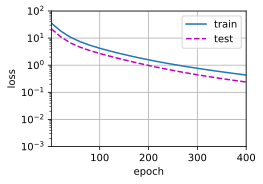

In [21]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.22756  4.085315]]


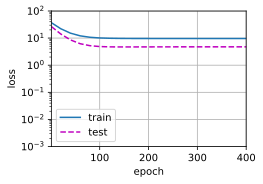

In [22]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.945338    1.3339156  -3.1681168   4.966863   -0.6237858   1.5983021
   0.21996129  0.33977285 -0.11858571 -0.09534918 -0.16568178  0.06235922
  -0.11825178 -0.02473043 -0.07341719  0.07564528  0.10952312 -0.15467072
  -0.15291043 -0.10347598]]


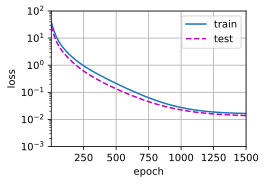

In [23]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)